# Pair Trading With Cryptos Part 2

## How To Implement A Pair-trading Strategy Using Python

## Introduction

Cryptocurrencies (or cryptos) captured the world's imagination during the last couple of years. From their spectacular rise in 2017, to their equally hard fall in 2018, and to their most recent revival this year. Cryptocurrencies and the blockchain engine powering them are regarded as disruptive forces proposing an alternative decentralized monetary system. They also garnered their fair share of criticism. Cryptocurrencies are accused of facilitating transfer of 'dirty money' between criminals. Due to the extremely volatile returns they provide, cryptocurrencies earned the reputation of being a 'get rich quick' scheme.

In this article, we focus on cryptocurrencies as investment vehicles sharing common features with FX, commodities and precious metals. Both crypto and fiat currencies allow for wealth transfer. Cryptocurrencies are similar to commodities because both have limited supply. They also draw comparisons to gold which is viewed by many as a "safe-haven" investment. 

This is the seconde part of the research. Recall that in the previous article, I illustrated how to source cryptocurrency historical data. In this article, I will present how to backest a pair-trading strategy using the collected data.

## Implementing A Pair-trading Strategy
The trading strategy is inspired from [E. Chan's](https://www.amazon.com/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889/ref=sr_1_1?crid=39RKR1QE7L1BS&keywords=quantitative+trading&qid=1558788312&s=gateway&sprefix=quantitativ%2Caps%2C500&sr=8-1) pair-trading system involving gold and gold index ETFs. Below are the rules for trading the spread:
- Enter a long position if it is below -1 STD.
- Enter a short position if the spread is above 1 STD.
- Exit the position if it is greater than -0.5 and less than 0.5 STD.

### Step By Step
1. Load historical data
2. Implement the pair-trading strategy 
3. Performance analysis of the trading strategy

You can find the code on https://github.com/DinodC/pair-trading-cryptos.

Import packages

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from pandas import Series, DataFrame

In [4]:
import pickle

In [5]:
import matplotlib.pyplot as plt

In [6]:
import statsmodels.api as sm

In [7]:
%matplotlib inline

## Load Data

Load the cryptocurrency data

In [8]:
with open('data_coinmarketcap.pickle', 'rb') as f:
    data = pickle.load(f)
    
f.close()

Create closing prices DataFrame object

In [9]:
close = pd.DataFrame({'BTC': data.BTC.Close,
                      'ETH': data.ETH.Close,
                      'LTC': data.LTC.Close,
                      'XRP': data.XRP.Close})

Create id list

In [10]:
id = ['BTC', 'ETH', 'LTC', 'XRP']

Plot

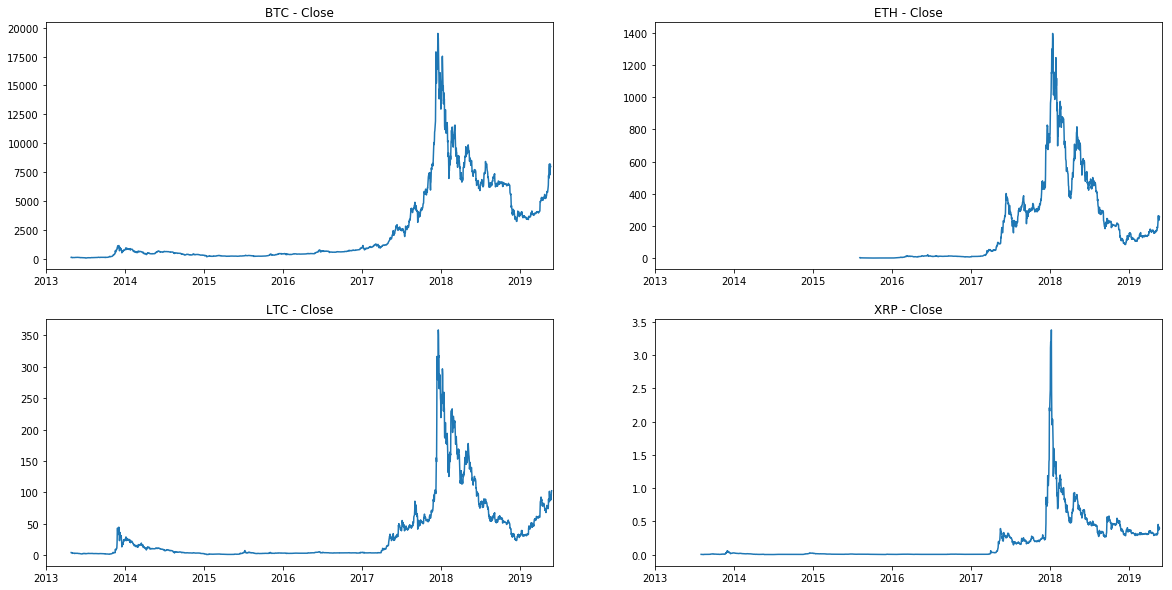

In [11]:
plt.figure(figsize=[20, 10])

for i in range(1, len(id)+1):    
    plt.subplot(2, 2, i)
    plt.plot(close[id[i-1]])
    plt.title(id[i-1] + ' - Close')
    plt.xlim('2013-01-01', '2019-06-01')


Note that ETH historical data is only available from July 2015 onwards.

## Pair-trading Strategy Implementation
Before starting with the backtest, recall the following things to look out for:
1. Data-snooping bias
2. Look-ahead bias
3. Transaction costs

### Correcting For Data-snooping Bias

Data-snooping bias is inflating a trading strategy's performance in the backtest. It can be due to overfitting a model by increasing the number of parameters to optimize backtesting performance. Data-snooping can also be caused by optimizing decisions in the trading strategy such as determining entry and exit levels, or choosing between small and large-cap stocks.

To mitigate for data-snooping bias, we can do the following:
1. Out-of-sample testing: 
Out-of-sample testing involves separating historical data into a training and test set. We optimize the model's parameters using the training set. We run the model on the test or out-of-sample set.
2. Paper trading:
Paper trading and out-of-sample testing share the same idea of separating the dataset. We optimize the model's parameters using the historical data. We run the model using incoming actual data. 

In this article, we only apply out-of-sample testing by dividing the dataset into two equal parts.

In [13]:
# Define training set
training_start = '2015-08-07'
training_end = '2017-08-01'
training_set = close[training_start:training_end]

# Define test set
test_start = '2017-08-02'
test_end = '2019-05-21'
test_set = close[test_start:test_end]

### Correcting For Look-ahead Bias
Look-ahead bias is using trading signal(s) based on information not yet available at the time of the trade.
An example is using the regression coefficients of a linear regression on price series.
The full price series is not available on any given trading day.

To control for look-ahead bias, we can do the following:
1. Backtest using historical data and save the positions.
2. Backtest using truncated historical data, e.g. 10 days, and save the positions.
3. Truncate the positions from point 1, e.g. 10 days, compare with the positions from point 2.

In this article, we implement the procedure to check for look-ahead bias (just after the backtest implementation).

### Including Transaction Costs
Transaction costs make the backtesting process more realistic. They deflate a trading strategy's performance by including the following:
1. Slippage is the difference between your expected price and the executed price.
2. Commission fee is a service charge extracted by your broker for handling your purchases.
3. Market impact is the price effect you genereate each time you pass a considerable order to the market.

In this article, we assume a round-trip transaction cost of 10 BPs per trade. 

In [14]:
# Round-trip transaction cost per trade
round_trip = 0.0005

### Implementation

We define the entry and exit thresholds

In [12]:
entry_threshold = 1
exit_threshold = 0.5

We implement the pair-trading strategy

In [15]:
# Set crypto 1 to BTC
crypto_1 = id[0]

# Initialize output
output = {id[1]: {},
          id[2]: {}, 
          id[3]: {}}

for i in range(1, len(id)):
    
    # Set crypto 2 to ETH, LTC and XRP
    crypto_2 = id[i]
    
    # Calculate the hedge ratio using the training set
    model = sm.OLS(training_set[crypto_1], training_set[crypto_2])
    result = model.fit()
    hedge_ratio = result.params[crypto_2]

    # Calculate the spread
    spread = close[crypto_1] - hedge_ratio * close[crypto_2]
    # Mean of the spread on the training set
    spread_mean = spread[training_start:training_end].mean()
    # Standard deviation of the spread calculated on the training set
    spread_std = spread[training_start:training_end].std()
    # Z-score of the spread
    z_score = (spread - spread_mean) / spread_std
    
    # Implement pair trading strategy
    # Create masks for long, short and exit positions
    longs = (z_score <= -entry_threshold)
    shorts = (z_score >= entry_threshold)
    exits = (np.abs(z_score) <= exit_threshold)
    # Initialize the positions
    positions = pd.DataFrame({crypto_1: np.nan * pd.Series(range(len(z_score))),
                              crypto_2: np.nan * pd.Series(range(len(z_score)))},
                             index=z_score.index)
    # Update the positions
    [positions[crypto_1][longs], positions[crypto_2][longs]] = [1, -1]
    [positions[crypto_1][shorts], positions[crypto_2][shorts]] = [-1, 1]
    [positions[crypto_1][exits], positions[crypto_2][exits]] = [0, 0]
    # Carry foward the positions except when there is an exit
    positions.fillna(method='ffill', inplace=True)
    # Lag the positions to the next day because we base calculations on close
    positions = positions.shift(periods=1)
    
    # Calculate the performance
    # Initialize the returns
    returns = pd.DataFrame({crypto_1: close[crypto_1],
                            crypto_2: close[crypto_2]})
    # Update the returns
    returns = returns.pct_change()
    # Calculate the pnl
    pnl = returns * positions

    # Calculate transaction costs
    # Create a mask to indicate changes in position
    mask = (~np.isnan(positions.BTC) & (positions.BTC - positions.BTC.shift(periods=1)).astype(bool))
    # mask = (~np.isnan(positions.BTC) & (positions.BTC != positions.BTC.shift(periods=1)))
    # Create a transaction costs Series
    tc = pd.Series(np.zeros(len(mask)), index=mask.index)
    tc[mask] = - round_trip
    
    # Update pnl DataFrame
    pnl['TC'] = tc
    # Calculate net pnl
    pnl_net = pnl.sum(axis='columns')
    
    # Calculate the Sharpe ratio under the training set
    sharpe_training = np.sqrt(252) * pnl_net[training_start:training_end].mean() / pnl_net[training_start:training_end].std()
    # Calculate the Sharpe ratio under the test set
    sharpe_test = np.sqrt(252) * pnl_net[test_start:test_end].mean() / pnl_net[test_start:test_end].std()
            
    # Generate the output
    # Gather data
    data = {'spread': z_score,
            'positions': positions,
            'pnl': pnl_net,
            'sharpe training': sharpe_training,
            'sharpe test': sharpe_test,
           }
    # Update the output
    output.update({crypto_2: data})
    

### Check For Look-ahead Bias

Load the output generated from the truncated historical data

In [16]:
with open('output_truncated.pickle', 'rb') as f:
    output_truncated = pickle.load(f)
    
f.close()

In [17]:
positions_truncated_eth = output_truncated['ETH']['positions'].dropna()
positions_truncated_ltc = output_truncated['LTC']['positions'].dropna()
positions_truncated_xrp = output_truncated['XRP']['positions'].dropna()

Truncate the positions calculated from the full dataset

In [18]:
positions_eth = output['ETH']['positions'][:-100].dropna()
positions_ltc = output['LTC']['positions'][:-100].dropna()
positions_xrp = output['XRP']['positions'][:-100].dropna()

Compare the two sets of positions

In [19]:
mask = positions_eth.eq(positions_truncated_eth)
mask.ETH.value_counts()

True    1216
Name: ETH, dtype: int64

In [20]:
mask = positions_ltc.eq(positions_truncated_ltc)
mask.LTC.value_counts()

True    2118
Name: LTC, dtype: int64

In [21]:
mask = positions_xrp.eq(positions_truncated_xrp)
mask.XRP.value_counts()

True    2020
Name: XRP, dtype: int64

## Performance Analysis

### Spread
Recall that the spread between BTC and other cryptocurrencies provides the signal of our trading strategy.

Plot the spread

(-50, 50)

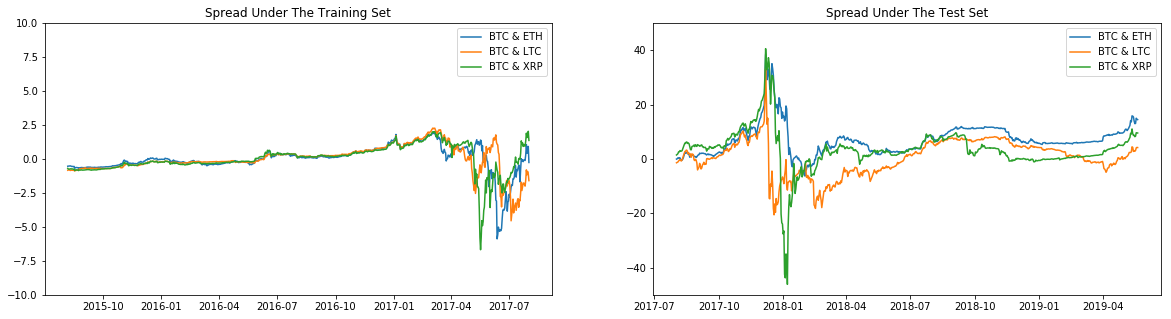

In [27]:
plt.figure(figsize=[20, 5])

plt.subplot(1, 2, 1)
plt.plot(output['ETH']['spread'][training_start:training_end])
plt.plot(output['LTC']['spread'][training_start:training_end])
plt.plot(output['XRP']['spread'][training_start:training_end])
plt.title('Spread Under The Training Set')
plt.legend(['BTC & ETH', 'BTC & LTC', 'BTC & XRP'])
plt.ylim(-10, 10)
plt.subplot(1, 2, 2)
plt.plot(output['ETH']['spread'][test_start:test_end])
plt.plot(output['LTC']['spread'][test_start:test_end])
plt.plot(output['XRP']['spread'][test_start:test_end])
plt.title('Spread Under The Test Set')
plt.legend(['BTC & ETH', 'BTC & LTC', 'BTC & XRP'])
plt.ylim(-50, 50)

Remarks:
- On the training set, the spread between BTC and cryptocurrencies followed a momentum process. This is true except for 2017 where the spread exhibited a mean-reverting process.
- On the test set, the spread between BTC and cryptocurrencies continued to show mean-reversion till the the end of 2017. From 2018 onwards, the spread reverted back to a momentum process.

### Sharpe Ratio

Table

In [23]:
sharpe = pd.DataFrame({'BTC & ETH': [output['ETH']['sharpe training'], output['ETH']['sharpe test']],
                       'BTC & LTC': [output['LTC']['sharpe training'], output['LTC']['sharpe test']],
                       'BTC & XRP': [output['XRP']['sharpe training'], output['XRP']['sharpe test']]},
                      index=pd.MultiIndex.from_product([['Sharpe Ratio'], ['Training Set', 'Test Set']]))

In [24]:
sharpe

BTC & ETH  BTC & LTC  BTC & XRP
Sharpe Ratio Training Set   1.821609   1.178973   1.273566
             Test Set      -0.198298   0.786512   0.483719

Remarks:
- On the training set, the Sharpe ratios are above 1 for each pair.
- On the test set, the Sharpe ratios diminished to less than 1. 
- A possible explanation is a change in regime of the spread. In the test set, the spread exhibited far less mean-reversion than in the training set.

### PnL

Plot

(-1, 10)

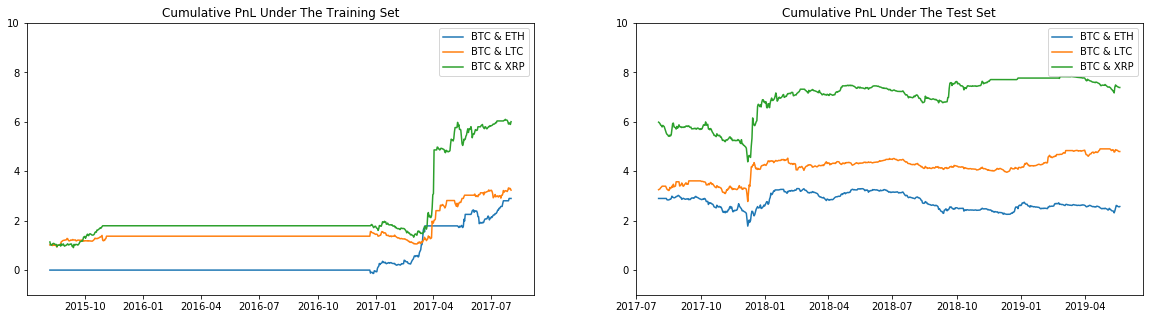

In [28]:
plt.figure(figsize=[20, 5])

plt.subplot(1, 2, 1)
plt.plot(output['ETH']['pnl'].cumsum()[training_start:training_end])
plt.plot(output['LTC']['pnl'].cumsum()[training_start:training_end])
plt.plot(output['XRP']['pnl'].cumsum()[training_start:training_end])
plt.title('Cumulative PnL Under The Training Set')
plt.legend(['BTC & ETH', 'BTC & LTC', 'BTC & XRP'])
plt.ylim(-1, 10)

plt.subplot(1, 2, 2)
plt.plot(output['ETH']['pnl'].cumsum()[test_start:test_end])
plt.plot(output['LTC']['pnl'].cumsum()[test_start:test_end])
plt.plot(output['XRP']['pnl'].cumsum()[test_start:test_end])
plt.title('Cumulative PnL Under The Test Set')
plt.legend(['BTC & ETH', 'BTC & LTC', 'BTC & XRP'])
plt.ylim(-1, 10)

Remarks:
- On the training set, the pair-trading strategy accumulated profits when the spread exhibited a mean-reverting process in 2017.
- On the test set, the pair-trading strategy accumulated less profits because the spread followed a momentum process.

## Conclusion

### Review The Main Takeaways
...